<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](./data/mountain/art1131.jpg)|![](./data/forest/cdmc317.jpg)|

The problem is realively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be something that you can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several differnet possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D()
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to additional additional full connected layers to our model. We we removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can expert with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = res.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(res.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

## Load in Data

![skimage-logo](https://scikit-image.org/_static/img/logo.png)

Check out out [`skimage`](https://scikit-image.org/) for useful functions related to processing the images. In particular checkout the documentation for `skimage.io.imread_collection` and `skimage.transform.resize`.

In [6]:
import numpy as np
import os, sys

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
from time import time
from time import sleep

Working with 328 images
Image examples: 
cdmc385.jpg


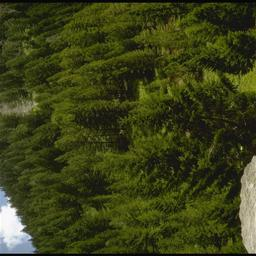

cdmc388.jpg


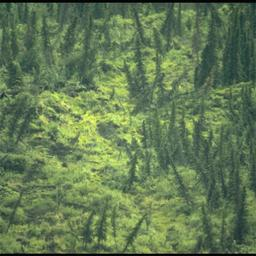

In [11]:
forest = ".\\data\\forest\\"

forest_pics = [f for f in os.listdir(forest) if os.path.isfile(os.path.join(
    forest, f)) and f[-3:] == 'jpg']

print("Working with {0} images".format(len(forest_pics)))
print("Image examples: ")

for i in range(40, 42):
    print(forest_pics[i])
    display(_Imgdis(filename=forest + "/" + forest_pics[i], width=240, height=320))

Working with 374 images
Image examples: 
land275.jpg


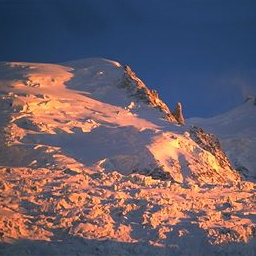

land278.jpg


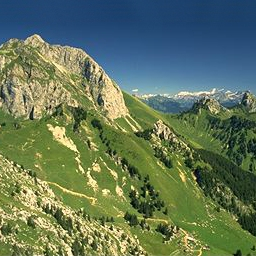

In [12]:

mountain = ".\\data\\mountain\\"

mountain_pics = [f for f in os.listdir(mountain) if os.path.isfile(
    os.path.join(mountain, f)) and f[-3:] == 'jpg']

print("Working with {0} images".format(len(mountain_pics)))
print("Image examples: ")

for i in range(40, 42):
    print(mountain_pics[i])
    display(_Imgdis(filename=mountain + "/" + mountain_pics[i], width=240, height=320))

In [14]:
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imread_collection, imshow_collection, imshow

In [18]:
img_list_mountain = []
for img in os.listdir(mountain):
    if img[-3:] == 'jpg':
        img_list_mountain.append(skimage.io.imread(f'.\\data\\mountain\\{img}'))

In [19]:
img_list_forest = []
for img in os.listdir(forest):
    if img[-3:] == 'jpg':
        img_list_forest.append(skimage.io.imread(f'.\\data\\forest\\{img}'))

In [20]:
img_list_forest[0].shape, img_list_mountain[0].shape

((256, 256, 3), (256, 256, 3))

In [21]:
from skimage import data
from skimage.transform import resize

# Testing the resize method
test_image = img_list_forest[0]
print(test_image.shape)
test_image = resize(test_image, (100, 100))
test_image.shape

(256, 256, 3)


(100, 100, 3)

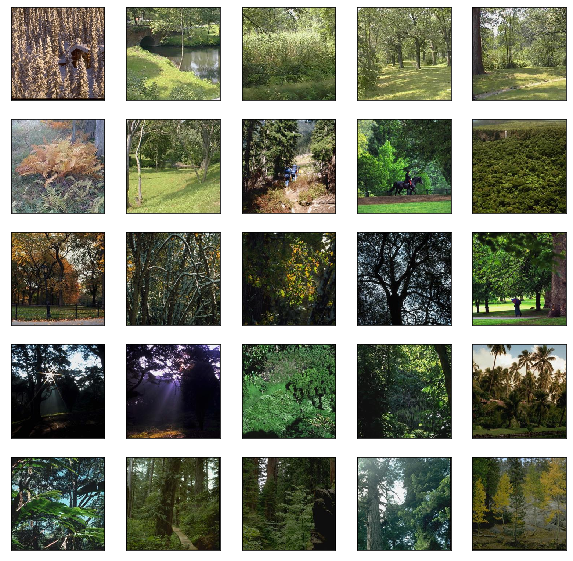

In [22]:
# Visualizing the forest set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_list_forest[i], cmap=plt.cm.binary)
plt.show()

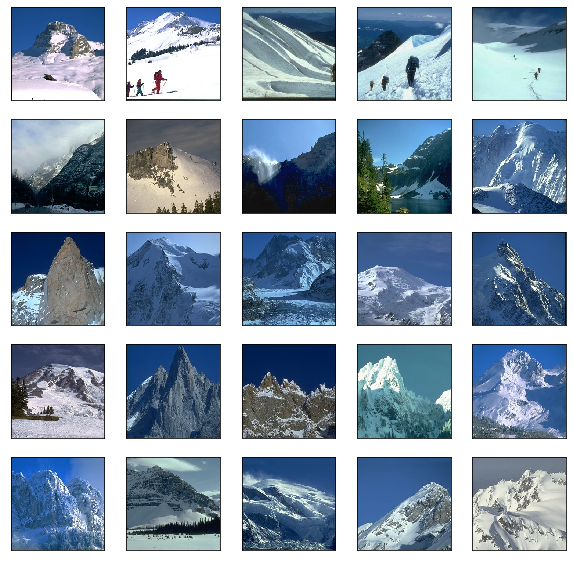

In [23]:
# Visualizing the mountain set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_list_mountain[i], cmap=plt.cm.binary)
plt.show()

In [24]:
forest_resized = []
for img in img_list_forest:
    new_img = img.copy()
    new_img = resize(new_img, (224, 224))
    forest_resized.append(new_img)

mountain_resized = []
for img in img_list_mountain:
    new_img = img.copy()
    new_img = resize(new_img, (224, 224))
    mountain_resized.append(new_img)

# Testing execution of above code: 
forest_resized[0].shape, mountain_resized[0].shape

((224, 224, 3), (224, 224, 3))

In [26]:
# Setting up the y column for positive and negative classes 

mountain_array = np.array(mountain_resized)
y_mountain = np.ones((mountain_array.shape[0],1))

forest_array = np.array(forest_resized)
y_forest = np.zeros((forest_array.shape[0], 1))

y_mountain.shape, y_forest.shape

((374, 1), (328, 1))

In [28]:
# Combining classified sets into one
from sklearn.model_selection import train_test_split

X = np.concatenate((mountain_array, forest_array))
y = np.concatenate((y_mountain, y_forest))

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((561, 224, 224, 3), (561, 1), (141, 224, 224, 3), (141, 1))

## Instatiate Model

In [29]:
resnet = ResNet50(weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)

def process_img_path(img_path):
  return image.load_img(img_path, target_size=(224, 224))

def img_contains_mountain(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  model = ResNet50(weights='imagenet')
  features = model.predict(x)
  results = decode_predictions(features, top=3)[0]
  print(results)
  for entry in results:
    if entry[1] == 'mountain':
      return entry[2]
  return 0.0

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Fit Model

In [33]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 561 samples, validate on 141 samples
Epoch 1/10
561/561 [==============================] - 63s 112ms/sample - loss: 0.3695 - accuracy: 0.8841 - val_loss: 1.0006 - val_accuracy: 0.4397
Epoch 2/10
561/561 [==============================] - 62s 111ms/sample - loss: 0.0537 - accuracy: 0.9840 - val_loss: 0.7276 - val_accuracy: 0.4397
Epoch 3/10
561/561 [==============================] - 58s 104ms/sample - loss: 0.0190 - accuracy: 0.9929 - val_loss: 0.6769 - val_accuracy: 0.5603
Epoch 4/10
561/561 [==============================] - 58s 104ms/sample - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.6869 - val_accuracy: 0.4752
Epoch 5/10
561/561 [==============================] - 59s 106ms/sample - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.6670 - val_accuracy: 0.6170
Epoch 6/10
561/561 [==============================] - 57s 102ms/sample - loss: 0.0146 - accuracy: 0.9964 - val_loss: 0.6996 - val_accuracy: 0.5603
Epoch 7/10
561/561 [==============================] - 58s 103ms/sample -

In [34]:
img_contains_mountain(X_train[0])

[('n06359193', 'web_site', 0.061110016), ('n03196217', 'digital_clock', 0.045091704), ('n03729826', 'matchstick', 0.04444729)]


0.0

In [36]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

141/141 - 6s - loss: 0.7122 - accuracy: 0.4610


# Custom CNN Model

In this step, write and train your own convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

In [37]:
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [38]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1

In [39]:
# Compile Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# Fit Model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 561 samples, validate on 141 samples
Epoch 1/10
561/561 [==============================] - 15s 27ms/sample - loss: 1.9564 - accuracy: 0.6168 - val_loss: 0.5953 - val_accuracy: 0.7376
Epoch 2/10
561/561 [==============================] - 15s 26ms/sample - loss: 0.2459 - accuracy: 0.9109 - val_loss: 0.3135 - val_accuracy: 0.8794
Epoch 3/10
561/561 [==============================] - 15s 27ms/sample - loss: 0.1759 - accuracy: 0.9376 - val_loss: 0.2619 - val_accuracy: 0.9078
Epoch 4/10
561/561 [==============================] - 15s 26ms/sample - loss: 0.1008 - accuracy: 0.9590 - val_loss: 0.3432 - val_accuracy: 0.8865
Epoch 5/10
561/561 [==============================] - 14s 26ms/sample - loss: 0.1240 - accuracy: 0.9554 - val_loss: 0.4127 - val_accuracy: 0.9007
Epoch 6/10
561/561 [==============================] - 14s 26ms/sample - loss: 0.0766 - accuracy: 0.9661 - val_loss: 0.3309 - val_accuracy: 0.9149
Epoch 7/10
561/561 [==============================] - 15s 26ms/sample - loss: 

In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

141/141 - 1s - loss: 0.5369 - accuracy: 0.8865


# Custom CNN Model with Image Manipulations
## *This a stretch goal, and it's relatively difficult*

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. Check out these resources to help you get started: 

1. [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class)
2. [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
 

In [ ]:
# State Code for Image Manipulation Here

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language